In [23]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [24]:
faceDetectClassifier = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")

In [25]:
def normalize(X):
    X = np.asarray(X)
    X /= 255
    return X

def read_images(path, size = 150):
    X,y = [], []
    
    for file_name in os.listdir(path):
        gray = cv2.imread(os.path.join(path,file_name),0)
        if len(gray):
            faces = faceDetectClassifier.detectMultiScale(gray, 1.2, 5)
            if len(faces):
                [x_i,y_i,w,h]  = faces[0]
                thing = gray[y_i: y_i + w, x_i: x_i + h]
                thing = cv2.resize(thing,(size,size))
                X.append(thing)

                labelRead = int(os.path.split(file_name)[1].split(".")[0].replace("subject", "")) - 1
                y.append(labelRead)
    
    return [np.asarray(X),np.asarray(y)]

In [26]:
def pca(X, y, num_components=0):
    [n,d] = X.shape
    if (num_components <= 0) or (num_components>n):
        num_components = n
    mu = X.mean(axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
    # or simply perform an economy size decomposition
    # eigenvectors, eigenvalues, variance = np.linalg.svd(X.T, full_matrices=False)
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    # select only num_components
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:,0:num_components].copy()
    return [eigenvalues, eigenvectors, mu]


In [27]:
def project(W, X, mu=None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X - mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y,W.T)
    return np.dot(Y, W.T) + mu

In [28]:
def subplot(title, images, rows, cols, sptitle="subplot", sptitles=[], colormap=cm.gray, ticks_visible=True, filename=None):
    fig = plt.figure()
    # main title
    fig.text(.5, .95, title, horizontalalignment='center') 
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows,cols,(i+1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)
        if len(sptitles) == len(images):
            plt.title("%s #%s" % (sptitle, str(sptitles[i])))
        else:
            plt.title("%s #%d" % (sptitle, (i+1)))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    if filename is None:
        plt.show()
    else:
        fig.savefig(filename)

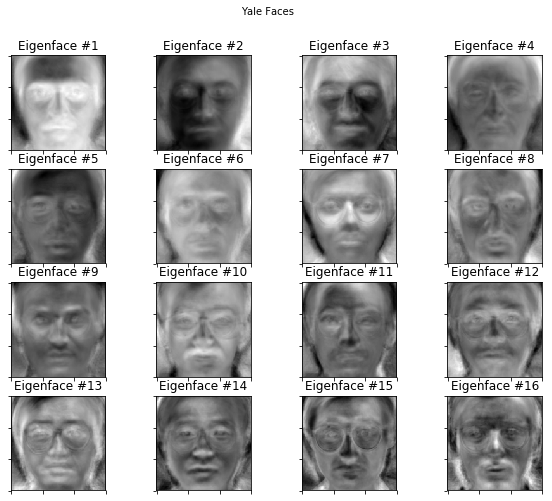

In [29]:
# read images
X, y = read_images("data/yalefaces")
nb_samples, h, w = X.shape
# perform a full pca
D, W, mu = pca(X.reshape(nb_samples,h*w), y)

# turn the first (at most) 16 eigenvectors into grayscale
# images (note: eigenvectors are stored by column!)
E = []
for i in range(min(len(X), 16)):
    e = W[:,i].reshape(X[0].shape)
    E.append(normalize(e))
# plot them
subplot(title="Yale Faces", images=E, rows=4, cols=4, sptitle="Eigenface", colormap=cm.gray)

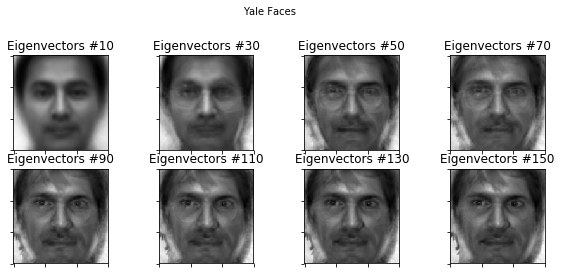

In [30]:
# reconstruction steps
steps=[i for i in range(10, min(len(X), 320), 20)]
E = []
for i in range(min(len(steps), 16)):
    numEvs = steps[i]
    P = project(W[:,0:numEvs], X[0].reshape(1,-1), mu)
    R = reconstruct(W[:,0:numEvs], P, mu)
    # reshape and append to plots
    R = R.reshape(X[0].shape)
    E.append(normalize(R))
# plot them
subplot(title="Yale Faces", images=E, rows=4, cols=4, sptitle="Eigenvectors", sptitles=steps, colormap=cm.gray)

In [31]:
def EuclideanDistance(p, q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    return np.sqrt(np.sum(np.power((p-q),2)))

def CosineDistance(p, q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    return -np.dot(p.T,q) / (np.sqrt(np.dot(p,p.T)*np.dot(q,q.T)))

In [46]:
class EigenFace:
    def __init__(self,X, y, num_components=0):
        self.X = X
        self.y = y
        self.num_components = num_components

        nb_samples, h, w = self.X.shape
        _, self.W, self.mu = pca(self.X.reshape(nb_samples,h*w), self.y, self.num_components)

        # return projections
        self.projections = []
        for xi in X:
            self.projections.append(project(self.W, xi.reshape(1,-1), mu))

    def predict(self, X_pred):
        minDist = np.finfo('float').max
        minClass = -1
        Q = project(self.W, X_pred.reshape(1,-1), self.mu)
        for i in range(len(self.projections)):
            dist = EuclideanDistance(self.projections[i], Q)
            if dist < minDist:
                minDist = dist
                minClass = y[i]
        return minClass

In [47]:
X,y = read_images('data/yalefaces')
# compute the eigenfaces model
model = EigenFace(X[1:], y[1:])
# get a prediction for the first observation
pred = model.predict(X[0])
print("expected =", y[0], "/", "predicted =", pred)

expected = 0 / predicted = 0


## References
1. https://github.com/bytefish/facerecognition_guide
1. https://en.wikipedia.org/wiki/Eigenface